# Simulating LSS from a GRF with the ZA

## Sampling a (3,1) Gaussian Random Field


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import camb  # import CAMB python module, use `pip install camb` or `pip install camb --user`

In [2]:
####################################################
N = 128  # we discretize our volume using N**3 cells

### Generating an uncorrelated (white) Gaussian random field


A white Gaussian random field with no correlations is a real scalar random field defined for every point of a multidimensional space $\mathcal{D}\subset\mathbb{R}^n$. It has a normal distribution at every point $x\in \mathcal{D}$ and the covariance between any two points $x,y\in S$ is given by:
$$ C(x,y) = \sigma^2 \delta(x-y) $$

where $\sigma^2$ is the variance of the field and $\delta(x-y)$ is the Dirac delta function. This means that the values of the field at different points are independent.

In [3]:
# create a Gaussian random field of size N**3
sigma2 = 1.0
delta0 = np.random.normal(size=[N,N,N]) * np.sqrt(sigma2)

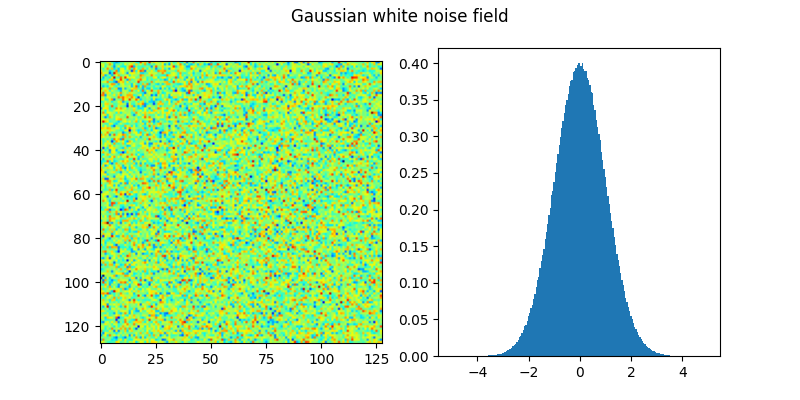

In [4]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
fig.suptitle('Gaussian white noise field')
ax[0].imshow(delta0[...,N//2], cmap='jet')
ax[1].hist(delta0.flatten(),bins=200,density=True);

## Obtain a power spectrum from CAMB

In [5]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_matter_power(redshifts=(1./np.linspace(0.1,1.0,10)-1), kmax=100.0)

#Linear spectra
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=1e2, var1='delta_tot',zmin=0.0, zmax=10.0)
s8 = np.array(results.get_sigma8())

print(f'sigma_8(z=0) = {s8[-1]}')

sigma_8(z=0) = 0.8027454642937086


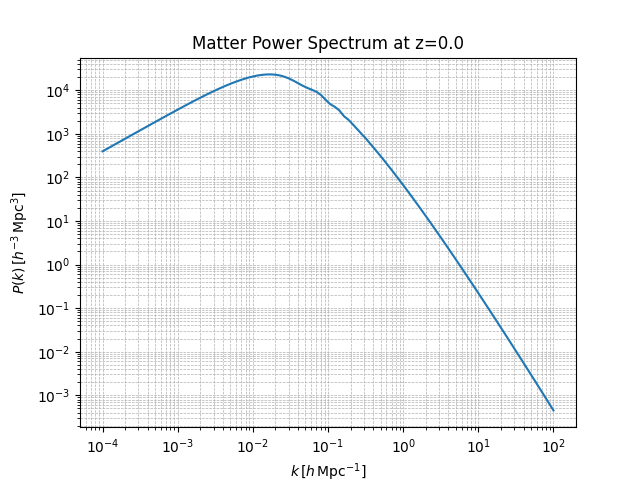

In [6]:
# Define the range of k values
k_values = np.logspace(-4, 2, 100)  # k values from 10^-3 to 10^2

# Get the power spectrum at z=0
zout = 0.0
P_k = PK.P(0.0, k_values)

# Plot the power spectrum
fig, ax = plt.subplots()
ax.loglog(k_values, P_k, label='Power Spectrum (z=0)')
ax.set_xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$P(k) \, [h^{-3} \, \mathrm{Mpc}^3]$')
ax.set_title(f'Matter Power Spectrum at z={zout}')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

## Generate a Gaussian random field with the given power spectrum

In [18]:
Lbox = 1000.  # define the box in Mpc/h
k0   = 2*np.pi / Lbox # the fundamental mode 

# set up Fourier mode indexing
kk = np.fft.fftfreq(N) * k0 * N
ks = np.fft.rfftfreq(N) * k0 * N
kvec = np.array(np.meshgrid(kk,kk,ks))
kmod = np.sqrt(np.sum(kvec**2,axis=0))
kny = k0 * N/2

In [19]:

kcut = 0.1 * kny

fdelta0 = np.fft.rfftn(delta0)
fdelta = fdelta0 * np.sqrt(PK.P(zout,kmod)) * N**1.5 / Lbox**1.5 #* np.exp(-0.5*(kmod/kcut)**2)
delta  = np.fft.irfftn(fdelta)

/Users/ohahn/venv-3.12/lib/python3.12/site-packages/camb/results.py:953: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))


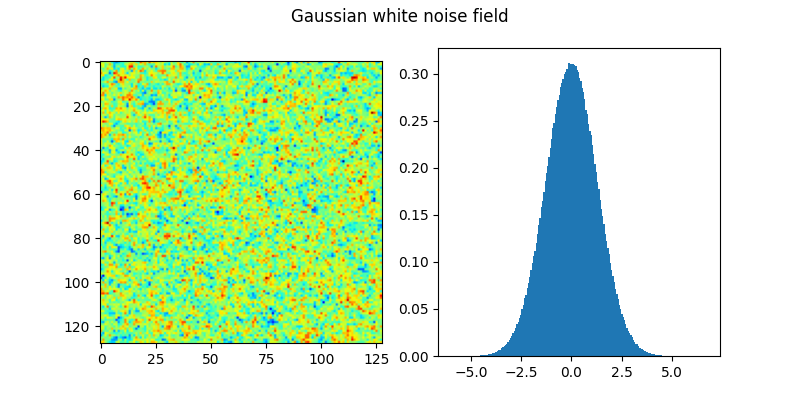

In [20]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
fig.suptitle('Gaussian white noise field')
ax[0].imshow(delta[...,N//2], cmap='jet')
ax[1].hist(delta.flatten(),bins=200,density=True);

## Generate displaced characteristic points using the Zel'dovich approximation

The Zel'dovich approximation approximates Vlasov-Poisson characteristics at first order. The displacement of a point $x$ is given by:
$$ X = q - D \nabla \varphi $$

In [25]:
# set up unperturbed particle mesh
qq = np.linspace(0,Lbox,N,endpoint=False)
xvec = np.array(np.meshgrid(qq,qq,qq))

# use Zeldovich to move particles
for i in range(3):
    psi_i = np.zeros_like(kmod,dtype=complex)
    mask = kmod > 0.0
    psi_i[mask] = -1j*kvec[i,mask]/kmod[mask]**2 * fdelta[mask]
    xvec[i,...] += 1.0 *np.fft.irfftn( psi_i ) 

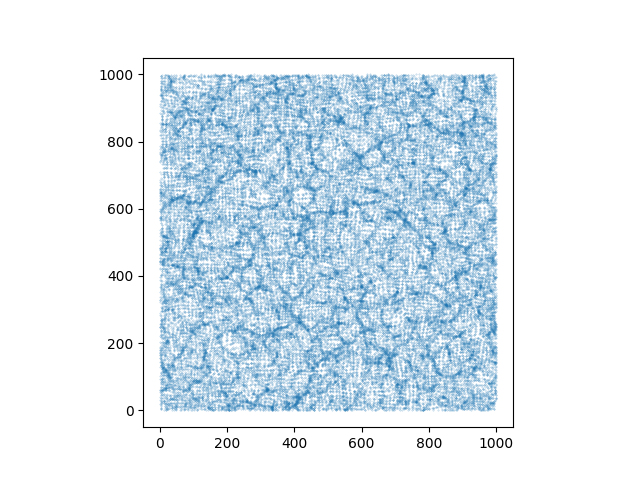

In [26]:
fig, ax = plt.subplots()
# plot particles with q-space z-coordinate in some range:
i0 = 0
i1 = 4
ax.scatter(np.fmod(Lbox+xvec[0,:,:,i0:i1],Lbox),np.fmod(Lbox+xvec[1,:,:,i0:i1],Lbox),s=0.1,alpha=0.4)
ax.set_aspect(1.0)

In [27]:
import pyvista as pv
# Extract x, y, z components from xvec
x, y, z = xvec[0].flatten(), xvec[1].flatten(), xvec[2].flatten()

# Combine into a single array of points
points = np.column_stack((x, y, z))
point_cloud = pv.PolyData(points)

In [28]:
# Create a PyVista plotter
plotter = pv.Plotter()

# Add the point cloud to the plotter
plotter.add_points(point_cloud, style="points_gaussian", color="black", point_size=1.0, render_points_as_spheres=False, opacity=0.05)

# Show the plot
plotter.show()

Widget(value='<iframe src="http://localhost:62169/index.html?ui=P_0x33ab275f0_2&reconnect=auto" class="pyvista…